In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import symmetric_methods as sm


In [2]:
L=4

dim = np.zeros((L+1,))

dim[0] = 7
dim[1] = 6
dim[2] = 5
dim[3] = 6
dim[4] = 7
#dim[5] = 5

dim= dim.astype(int)

npar = 0
cpar = np.zeros((L+1,))
for iL in range(L):
    npar = npar + dim[iL] * dim[iL+1]
    cpar[iL+1] = npar
npar = npar.astype(int)
cpar = cpar.astype(int)

print(npar)
    
num_train_data = 500
num_test_data = 500

#num_train_data = 150
#num_test_data = 150

noise = 0

144


### Create Neural Network

In [3]:

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [nn.Linear(dim[0],dim[1],bias=False)]
        for iL in np.arange(1,L):
            layers.append(nn.ReLU())
            layers.append(nn.Linear(dim[iL],dim[iL+1],bias=False))        
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)



# Define a custom initialization function using Gaussian distribution
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        # Gaussian initialization 
        y = m.in_features
        nn.init.normal_(m.weight, mean=0.0, std=1/np.sqrt(y)) 


net_teacher = Net()
net_teacher.apply(initialize_weights)

net = Net()
net.apply(initialize_weights)

net0 = Net()
net0.load_state_dict(net.state_dict())

num_parameters = sum(param.numel() for param in net.parameters())
print(num_parameters)


144


In [ ]:
# print list of all parameter tensors
print(list(net.parameters()))

### Input data

In [5]:

# Permutation invariant input

inputs_train =  torch.rand((num_train_data,1))# @ torch.ones((1, dim[0]))
inputs_test = torch.rand((num_test_data,1))# @ torch.ones((1, dim[0]))





### Output data

In [6]:




# identity mapping

with torch.no_grad():
    labels_train = torch.clone(inputs_train) 
    labels_test = torch.clone(inputs_test) 

inputs_train = inputs_train @ torch.ones((1, dim[0]))
inputs_test = inputs_test @ torch.ones((1, dim[0]))

labels_train = labels_train @ torch.ones((1, dim[L]))
labels_test = labels_test @ torch.ones((1, dim[L]))



### Gradient statistics

In [7]:
N = 100000

avggrad = torch.zeros(num_parameters,1)
covgrad = torch.zeros(num_parameters,num_parameters)
grad_rec = torch.zeros(num_parameters,N)

for iN in np.arange(0,N):
    
    if (iN+1)%(N/100)==0:
        print(iN+1)
    
    net.apply(initialize_weights)

    # Forward pass
    outputs_train = net(inputs_train)

    # Compute the loss
    loss = torch.norm(outputs_train-labels_train)**2 / 2

    # Compute first-order gradients (Jacobian)
    grads = torch.autograd.grad(loss, net.parameters())

    # Flatten gradients of all tensors (in column major order, Fortran style!)
    grad_all = torch.cat([g.T.reshape(-1,1) for g in grads])
    grad_rec[:,iN] =  torch.squeeze(grad_all)
    
    avggrad += grad_all
    covgrad += grad_all @ grad_all.T
    
avggrad /= N
covgrad /= N

covgrad = covgrad - avggrad @ avggrad.T


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000


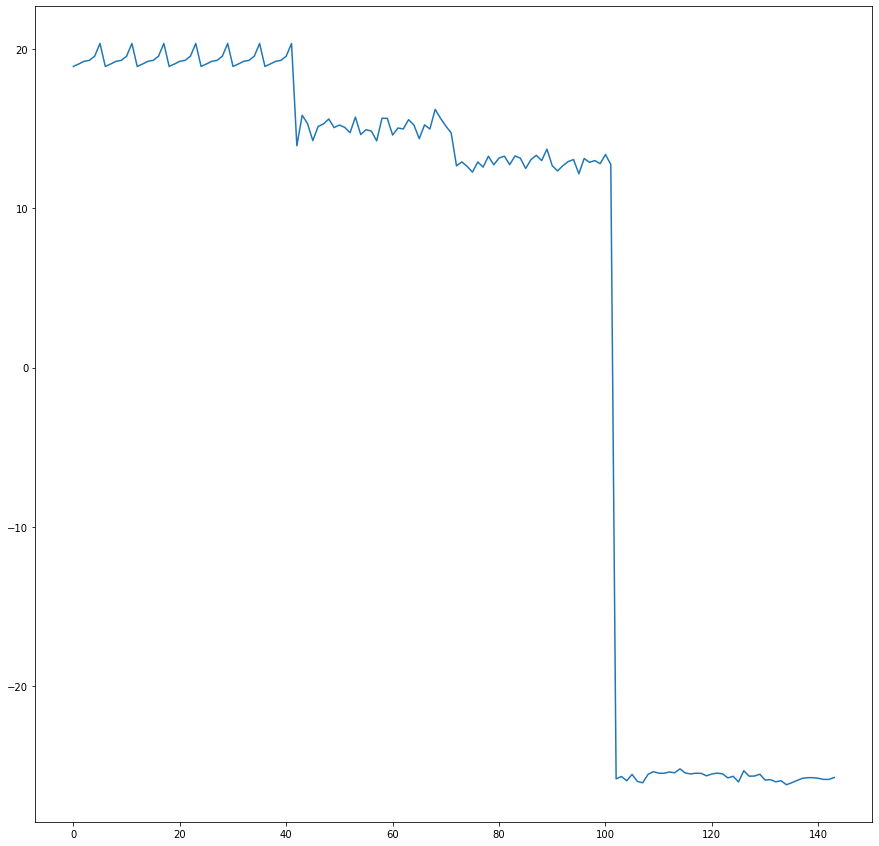

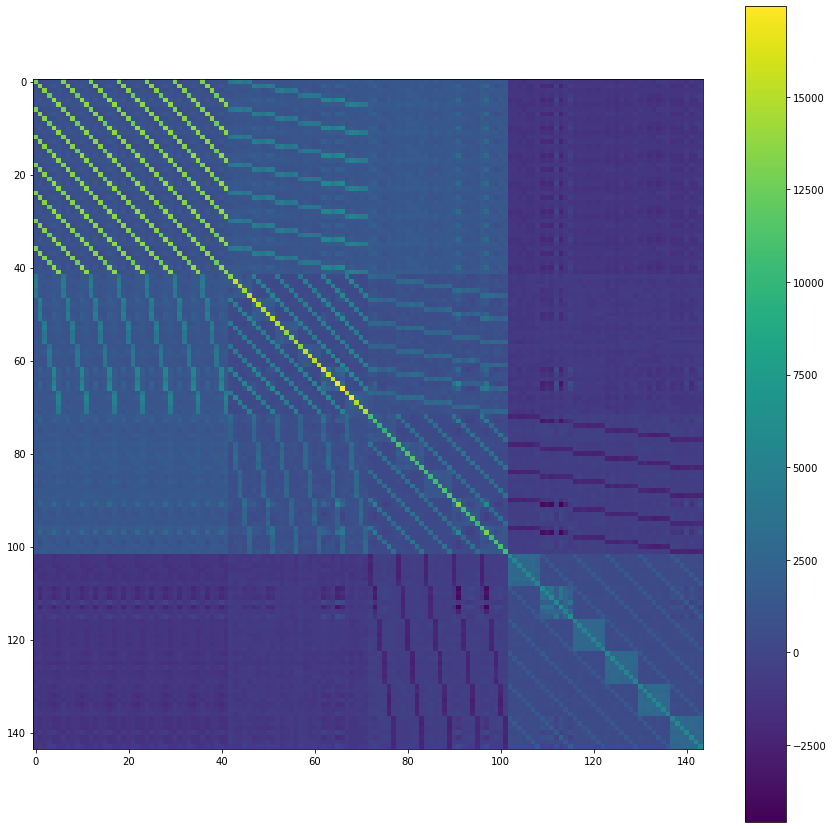

In [9]:

plt.plot(avggrad)
#plt.plot(grad_all)
fig = plt.gcf()
fig.set_size_inches(15, 15)
#plt.ylim((-10,10))
plt.show()

plt.imshow(covgrad)
plt.colorbar()
#plt.clim((-10**6,10**6))
fig = plt.gcf()
fig.set_size_inches(15, 15)
plt.show()



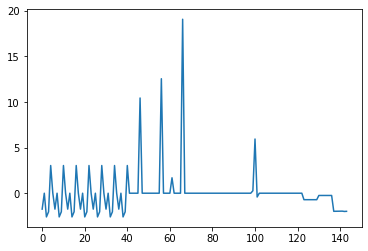

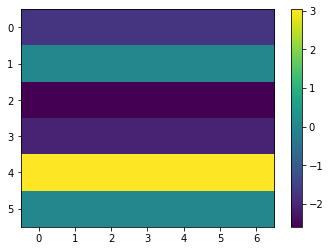

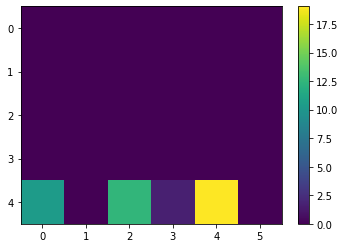

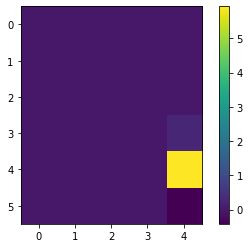

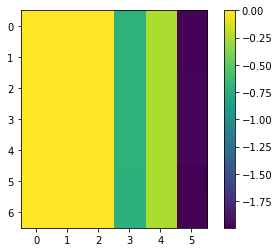

In [10]:

jN = 6

plt.plot(grad_rec[:,jN])
plt.show()

for iL in range(L):
    plt.imshow(np.reshape(grad_rec[cpar[iL]:cpar[iL+1],jN],(dim[iL+1],dim[iL]),order='F'))
    plt.colorbar()
    plt.show()






In [11]:

wd, wt, wo = sm.cov2par(L,dim,covgrad.numpy())

print(wd)

print(wt)

print(wo)


[[ 3.63797881e-11  9.07083662e+03  6.36665182e+03  1.87815173e+03]
 [-1.45519152e-11  6.10048072e+03  5.75937508e+03  1.65583898e+04]
 [ 8.68270842e+04  2.73761964e+04  1.63941805e+04  5.93526677e+03]
 [ 3.82272313e+04  1.31405368e+04  1.02331315e+04  1.79714872e+04]]
[[ 18962.65489707  11720.10063744 -10922.99856736]
 [ 45898.37673916  24096.84709358 -17682.63979918]]
[ 53083.61897788 -50214.39404297 -33294.90190163]


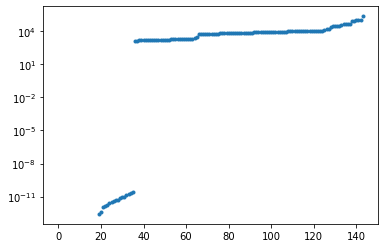

[-1.58437031e-11 -1.35382859e-11 -1.29334130e-11 -1.10502840e-11
 -9.15970251e-12 -8.60824259e-12 -8.52490474e-12 -6.72614612e-12
 -6.58282196e-12 -5.06677166e-12 -4.01330922e-12 -3.88250803e-12
 -3.52595860e-12 -3.31095307e-12 -2.84462861e-12 -1.93841189e-12
 -1.62818966e-12 -9.58494026e-13 -6.52279392e-13  2.79813526e-13
  4.05684384e-13  1.22816687e-12  1.38339839e-12  1.85157467e-12
  2.99468631e-12  3.48502715e-12  4.10433840e-12  5.08870550e-12
  5.37449512e-12  7.57141658e-12  9.45048640e-12  1.00851758e-11
  1.43189237e-11  1.68569863e-11  2.41079882e-11  2.60194141e-11
  1.30084595e+03  1.36589502e+03  1.40125525e+03  1.41776306e+03
  1.43921533e+03  1.44656042e+03  1.46690906e+03  1.52533130e+03
  1.55070264e+03  1.56874524e+03  1.61403394e+03  1.61583167e+03
  1.65217651e+03  1.66513403e+03  1.69243481e+03  1.69599377e+03
  1.71176270e+03  1.72415784e+03  1.74224512e+03  1.77021997e+03
  1.83297900e+03  1.87713428e+03  1.88192517e+03  1.92601282e+03
  1.95334351e+03  1.98953

In [12]:

evl, evc = np.linalg.eigh(covgrad)

plt.plot(evl,linestyle='none',marker='.')
plt.yscale('log')
#plt.ylim((10**(2),10**(6)))
plt.show()

print(evl)


In [13]:

for iL in range(L):
    print(torch.mean(grad_all[cpar[iL]:cpar[iL+1]]))


tensor(-9.3661)
tensor(-1.9089)
tensor(-1.1717)
tensor(-2.5334)


In [14]:

covg = sm.par2cov(L,dim,wd,wt,wo)

dim_small = np.zeros((L+1,))
for iL in range(L+1):
    dim_small[iL] = 2
dim_small = dim_small.astype(int)

covg_small = sm.par2cov(L,dim_small,wd,wt,wo)






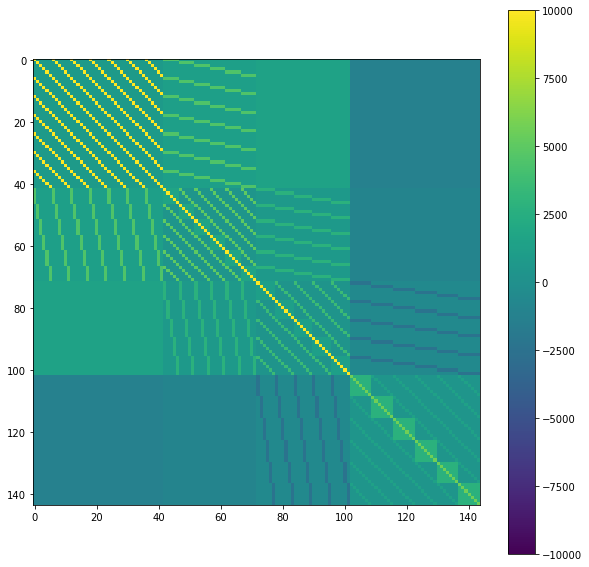

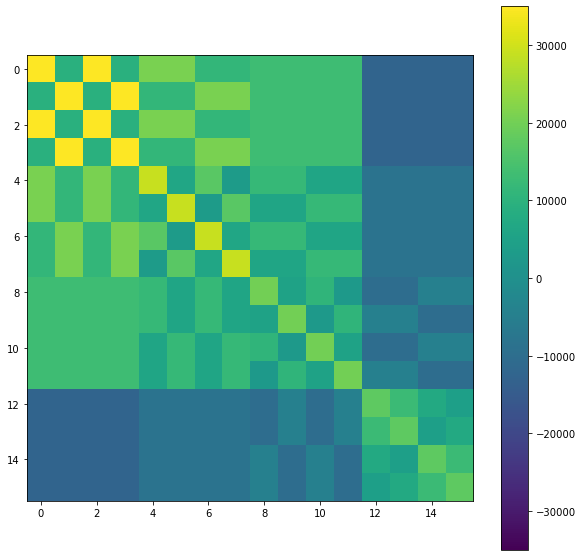

In [15]:

plt.imshow(covg)
plt.colorbar()
plt.clim((-10000,10000))
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()


plt.imshow(covg_small)
plt.colorbar()
plt.clim((-35000,35000))
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()



